**Fontes**

Dados de óbitos entre vacinados e não vacinados na Inglaterra até o dia 20/08/2021: [SARS-CoV-2 variants of concern and variants under investigation in England Technical briefing 22](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1014926/Technical_Briefing_22_21_09_02.pdf)

Status de vacinação nos países do Reino Unido até dia 20/08/2021: [https://ourworldindata.org/coronavirus/country/united-kingdom](https://ourworldindata.org/coronavirus/country/united-kingdom)

Dados de cobertura vacinal por faixa etária na Escócia: [https://www.opendata.nhs.scot/dataset/covid-19-vaccination-in-scotland](https://www.opendata.nhs.scot/dataset/covid-19-vaccination-in-scotland)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import os
from google.colab import drive
from google.colab import files
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import datetime
from matplotlib.patches import Patch
from scipy.integrate import odeint, quad
from random import choices
import time

drive.mount("/content/gdrive")

Mounted at /content/gdrive


Algumas coisas serão extrapoladas aqui. Em primeiro lugar, a idade média das pessoas vacinadas e não vacinadas na Inglaterra é extremamente diferente. Como a vacinação começou a avançar entre os mais velhos, o grupo de vacinados inclui muito mais pessoas velhas do que o grupo de não vacinados, assim, qualquer comparação entre os dois grupos sem considerar é isso é errônea. Para tentar minimizar este fator, considerarei apenas o grupo de pessoas acima de 50 anos. Isso ainda não elimina totalmente o problema, já que a fatalidade da COVID cresce exponencialmente com a idade, o ideal seria separar em grupos de 10 em 10 anos. Porém, os dados que adquiri, apenas separam a ocorrência de casos entre vacinados e não vacinados pelos menores de 50 e os 50+.

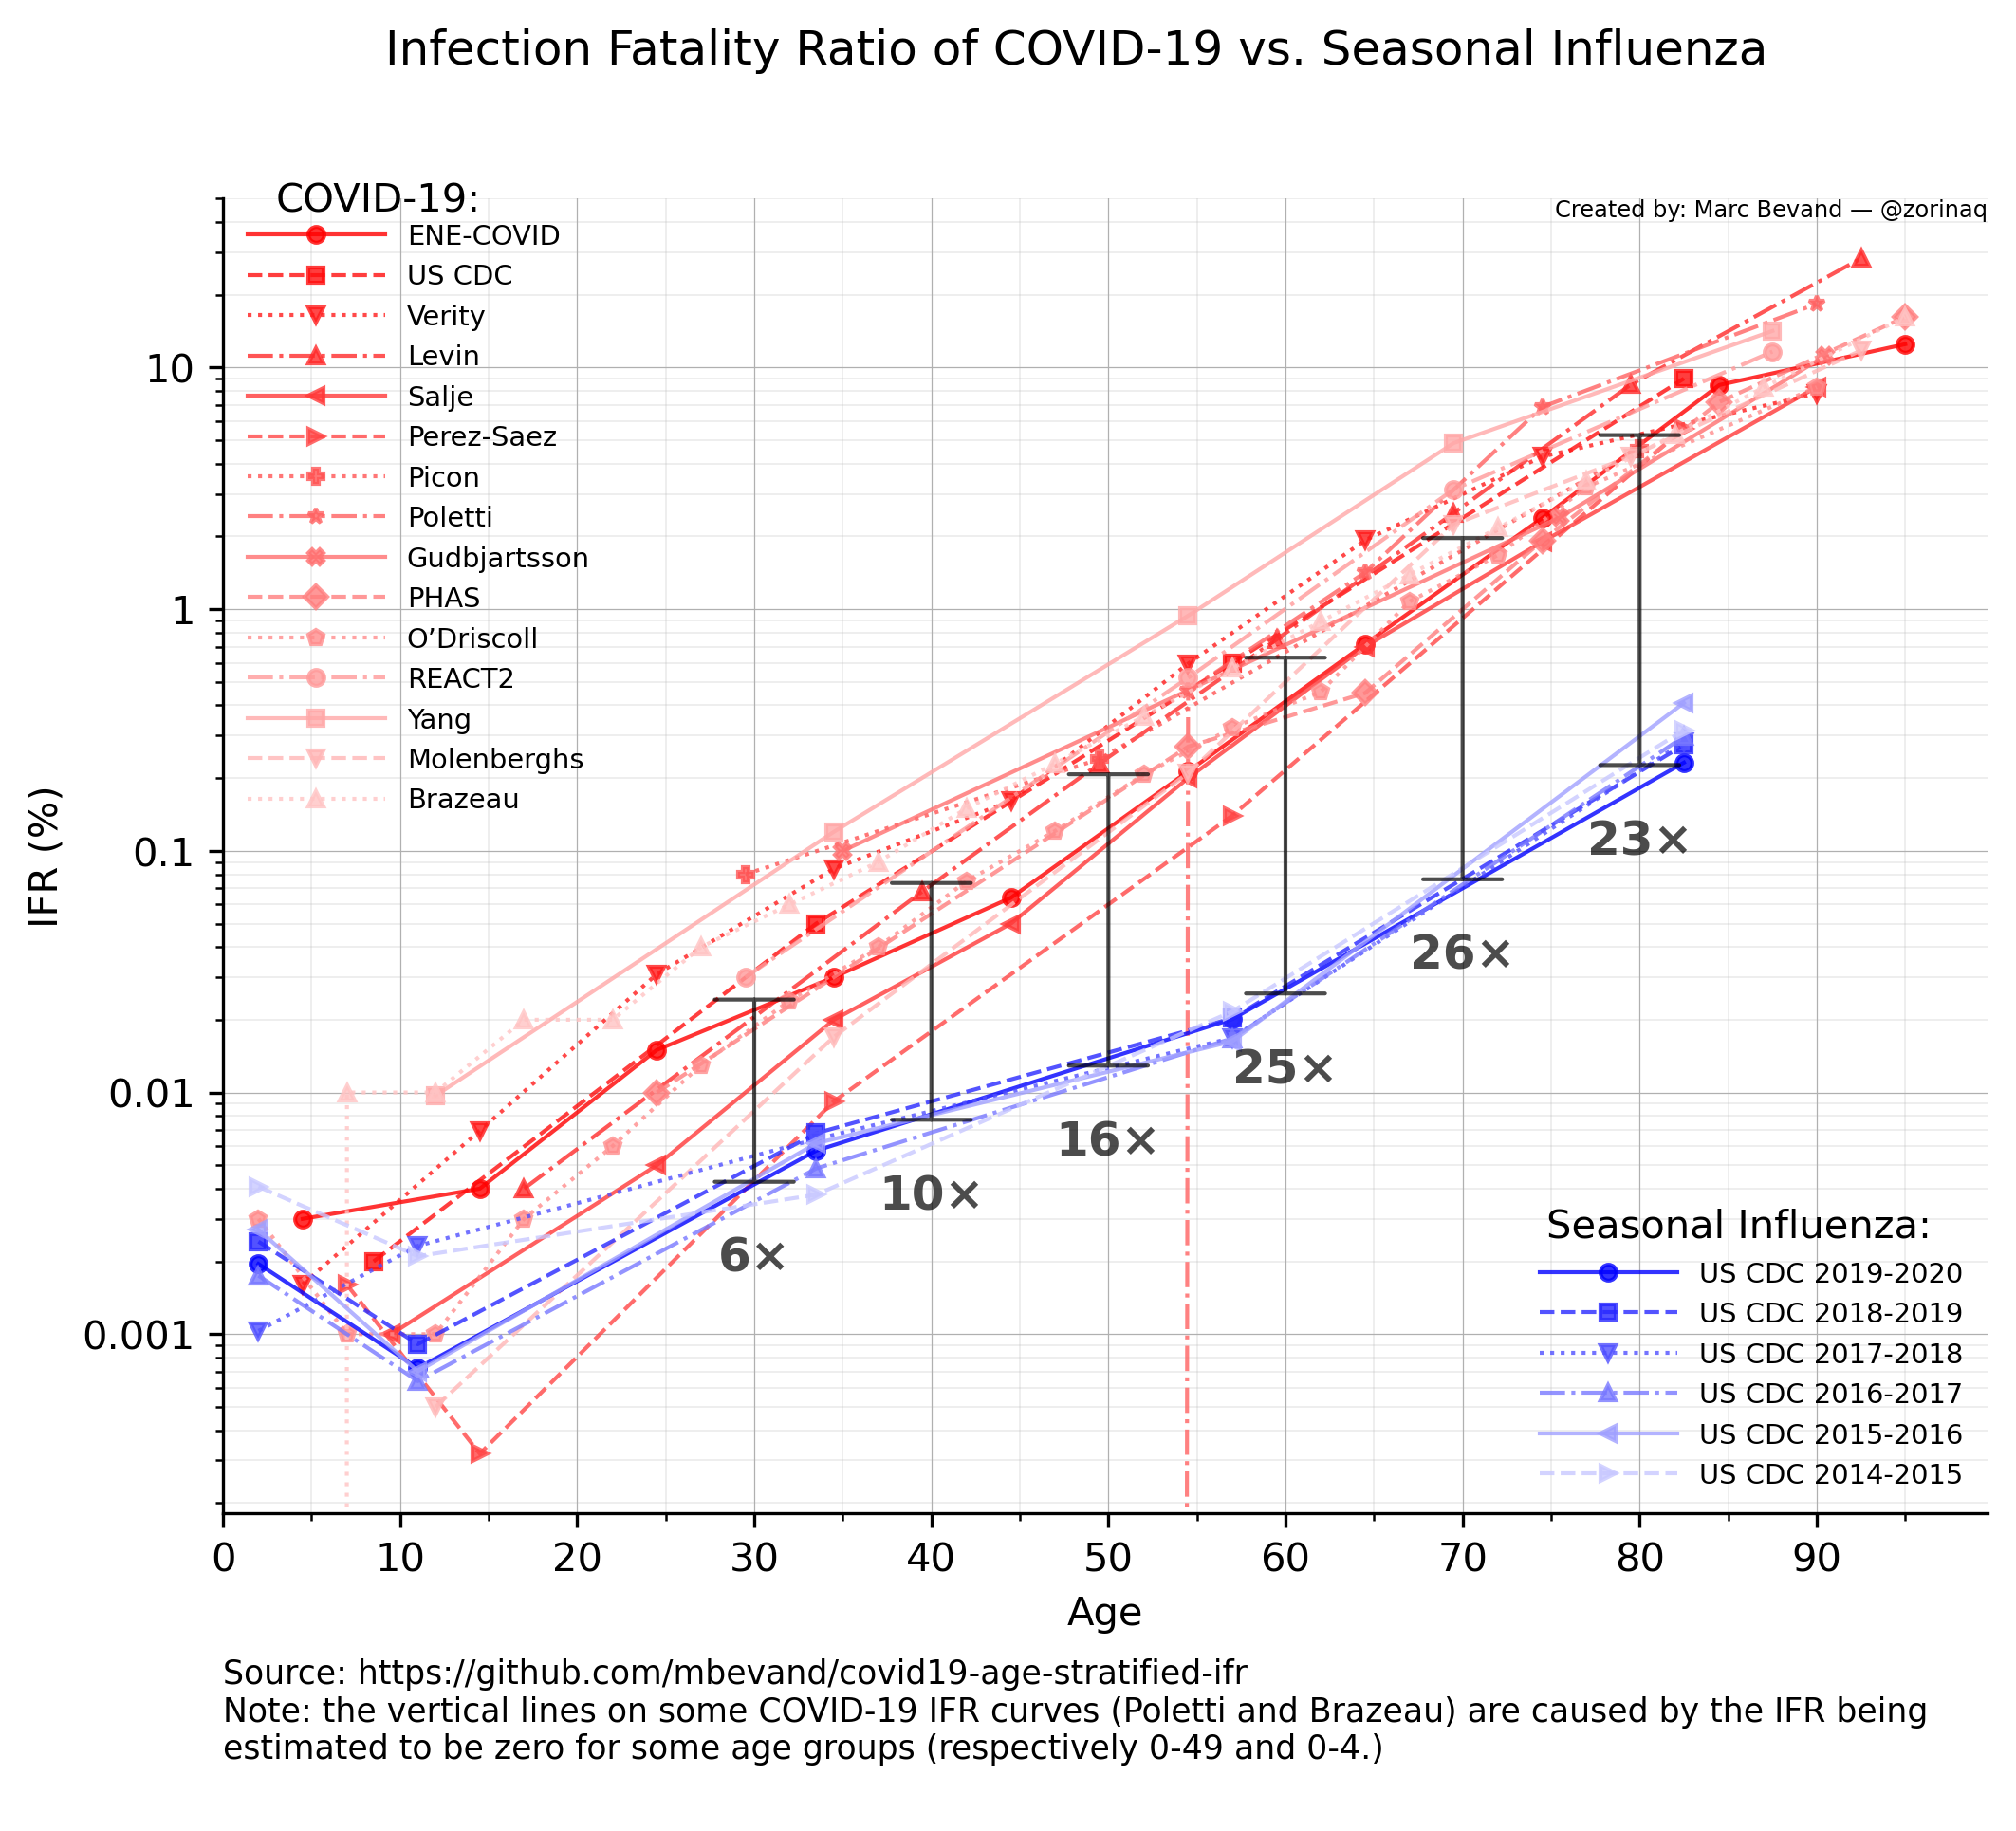

Em segundo lugar, como o Reino Unido inteiro possuiu um avanço na vacinação parecido (gráfico abaixo), irei extrapolar a cobertura vacinal de maiores de 50 na Escócia para a Inglaterra, diminuindo a diferença de cobertura total entre os dois países. Ou seja, estou assumindo que a diferença de cobertura entre os dois países se mantem uniforme dentro das faixas etárias. Isso introduz uma margem de erro nas estimativas de cobertura vacinal atual da população maior que 50 anos na Inglaterra.

O relatório mais recente da vigilância de COVID e Influenza na Inglaterra ([National flu and COVID-19 surveillance report: 8 July 2021 (week 27)](https://www.gov.uk/government/statistics/national-flu-and-covid-19-surveillance-reports)) afirma que mais de 80% da população maior de 50 recebeu as duas doses de vacina. Sendo assim, a margem de erro inferior não pode ficar abaixo de 80%.

No dia 20 de Agosto, até onde todos os dados utilizados aqui vão, a diferença de cobertura vacinal com 2 doses entre a Escócia e a Inglaterra é de $64.8-61.3 = 3.5 \%$. Irei assumir uma possível margem de variação correspondendo a este valor, ou seja, se a Escócia possuir uma cobertura de 90% para maiores de 50 anos, por exemplo, irei assumir que na Inglaterra a cobertura é de 86.5 $\pm$ 3.5% (isso siginifca que a cobertura varia de 83-90%). E assim, irei estimar a efetividade da vacinação para a margem de erro superior e inferior.

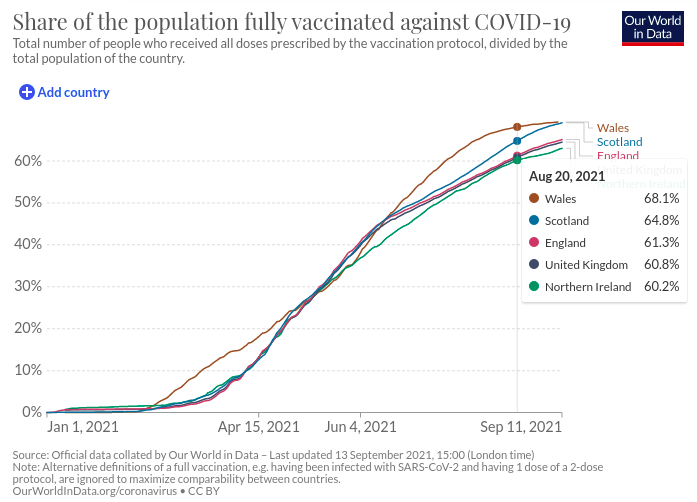

In [72]:
vac = pd.read_csv('../Scotland_vaccinations_by_sex_and_age.csv')

In [73]:
vac['Date'] = pd.to_datetime(vac['Date'], format = '%Y%m%d')

In [74]:
tot_vac = vac.loc[vac['Sex'] == 'Total']
tot_vac_1st = tot_vac.loc[tot_vac['Dose'] == 'Dose 1']
tot_vac_2nd = tot_vac.loc[tot_vac['Dose'] == 'Dose 2']

In [75]:
dates = ['20-08-2021']

In [76]:
for i in range(len(dates)):
  pieces = dates[i].split('-')
  dates[i] = pieces[2]+'-'+pieces[1]+'-'+pieces[0]

In [77]:
vacs_scot_1st = {}
vacs_scot_1st['Ages'] = ['18 - 29', '30 - 39', '40 - 49', '50 - 54', '55 - 59', '60 - 64',
                        '65 - 69', '70 - 74', '75 - 79', '80 years and over']

vacs_scot_2nd = {}
vacs_scot_2nd['Ages'] = ['18 - 29', '30 - 39', '40 - 49', '50 - 54', '55 - 59', '60 - 64',
                        '65 - 69', '70 - 74', '75 - 79', '80 years and over']

In [79]:
for i in range(len(dates)):
  date = dates[i]
  vacs_scot_1st[date] = [0 for k in range(len(vacs_scot_1st['Ages']))]
  vacs_scot_2nd[date] = [0 for k in range(len(vacs_scot_1st['Ages']))]
  vacs_1 = tot_vac_1st.loc[tot_vac_1st['Date'] == f'{date}']
  vacs_1 = vacs_1.reset_index(drop=True)
  vacs_2 = tot_vac_2nd.loc[tot_vac_2nd['Date'] == f'{date}']
  vacs_2 = vacs_2.reset_index(drop=True)
  for idx in range(len(vacs_1)):
    for j in range(len(vacs_scot_1st['Ages'])):
      if vacs_1['AgeGroup'][idx] == vacs_scot_1st['Ages'][j]:
        if vacs_1['CumulativePercentCoverage'][idx] > 100:
          vacs_scot_1st[date][j] += 100
        else:
          vacs_scot_1st[date][j] += vacs_1['CumulativePercentCoverage'][idx]
  for idx in range(len(vacs_2)):
    for j in range(len(vacs_scot_2nd['Ages'])):
      if vacs_2['AgeGroup'][idx] == vacs_scot_2nd['Ages'][j]:
        if vacs_2['CumulativePercentCoverage'][idx] > 100:
          vacs_scot_2nd[date][j] += 100
        else:
          vacs_scot_2nd[date][j] += vacs_2['CumulativePercentCoverage'][idx]

In [80]:
vacs_scot_1st['Ages'][-1] = '80+'
vacs_scot_2nd['Ages'][-1] = '80+'

In [81]:
scotland_vaccinations_age_1st = pd.DataFrame(vacs_scot_1st).set_index('Ages')
scotland_vaccinations_age_2nd = pd.DataFrame(vacs_scot_2nd).set_index('Ages')

In [82]:
scotland_vaccinations_age_2nd

,2021-08-20
Ages,
18 - 29,38.224491
30 - 39,67.821881
40 - 49,83.725400
50 - 54,92.509279
55 - 59,96.177231
60 - 64,99.755509
65 - 69,99.686785
70 - 74,99.140748
75 - 79,100.000000


In [105]:
cover_england = np.mean(scotland_vaccinations_age_2nd['2021-08-20'].values[3:])-3.5
print(cover_england)

94.6813644878723


Agora podemos estimar qual a fração de desfechos invasores (em inglês se usa o termo _breakthrough_, para se referir a desfechos como doença sintomática, hospitalização ou óbito em pessoas já completamente vacinadas). Essa estimativa é dada por

$$ B^d(V_{ax}|V_{E}^{d}) = \frac{V_{ax}(1-V_{E}^{d})}{V_{ax}(1-V_{E}^{d}) + (1-V_{ax})}$$

onde $V_{ax}$ é a parcela total da população vacinada e $V_{E}^{d}$ é a efetividade da vacina contra o desfecho $d$, e $B^d$ é a fração de desfechos $d$ invasores. Neste caso, iremos cosiderar o desfecho $d=$ óbito, portanto, estaremos calculado a quantidade esperada de óbitos invasores nos maiores de 50 anos, dada a efetividade da vacinação na Inglaterra e a % da população acima de 50 anos já vacinada.

A efetividade de uma vacina é diferente de sua eficácia. A eficácia diz respeito a diminuição no risco de um desfecho específico. Já a efetividade diz respeito a como a vacina se comporta no mundo real, sendo assim, ela depende de vários fatores sociais como a exposição das pessoas, a mobilidade, a % de pessoas vacinadas e a combinação de vacinas utilizadas. A efetividade, de forma muito simplificada, pode ser calculada como

$$ V_{E}^{d} = \sum_{j=i}^M \sum_{i=1}^N \alpha_j w_{ij} p_{ij}^{d} $$

onde $w_{ij}$ é um peso associado à fração da população do grupo etário $j$ vacinada que recebeu a $i$-ésima vacina de eficácia protetora $p_{ij}^{d}$ contra o desfecho $d$ e $\alpha_j$ a fração da população que está na faixa etária $j$. Portanto, $w_{ij}$ é uma matriz do tipo (uso da vacina $\times$ idade). Temos $N$ vacinas e $M$ grupos etários. Por exemplo

| Vaccine | 50-59 | 60-69 | 70+ |
|:-------:|:----:|:-----:|:---:|
|Pfizer| 0.54 | 0.43 | 0.67 |
|Moderna| 0.4 | 0.37 | 0.29 |
|Janssen| 0.06 | 0.2 | 0.04 |

enquanto que $p_{ij}$ é uma matriz do tipo (eficácia da vacina $\times$ idade). Por exemplo

| Vaccine | 50-59 | 60-69 | 70+ |
|:-------:|:----:|:-----:|:---:|
|Pfizer| 0.98 | 0.97 | 0.67 |
|Moderna| 0.98 | 0.97 | 0.65 |
|Janssen| 0.81 | 0.76 | 0.52 |

Isso supõe que tanto as pessoas vacinadas como não vacinadas possuem mobilidades parecidas e riscos de se expor parecidos. Como restringiremos nossa análise à população acima de 50 anos, vamos supor apenas 1 único grupo etário, correspondendo aos maiores de 50 anos. Sendo assim, $M=1$

$$ V_{E}^{d} = \sum_{i=1}^N w_{i} p_{i}^{d} $$

In [42]:
def VE(percents: np.array, ves: np.array):
  return np.sum(percents*ves)

Infelizmente, também não encontrei a fração de pessoas vacinadas com cada uma das vacinas usadas na Inglaterra, em cada faixa etária. Portanto, a única variável que teremos será $V_{E}^{d}$, que é a efetividade geral da vacinação na população maior que 50 anos na Inglaterra.

In [16]:
def breakthrough(percent_vax, VE):
  return (percent_vax*(1-VE))/(percent_vax*(1-VE) + (1-percent_vax))

In [120]:
c, cov = curve_fit(breakthrough, [cover_england/100], [0.64])
c2, cov2 = curve_fit(breakthrough, [(cover_england-3.5)/100], [0.64])
c3, cov3 = curve_fit(breakthrough, [(cover_england+3.5)/100], [0.64])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [124]:
c3[0]-c[0]

0.06693479629451526

In [107]:
x = np.linspace(0,1,10000)

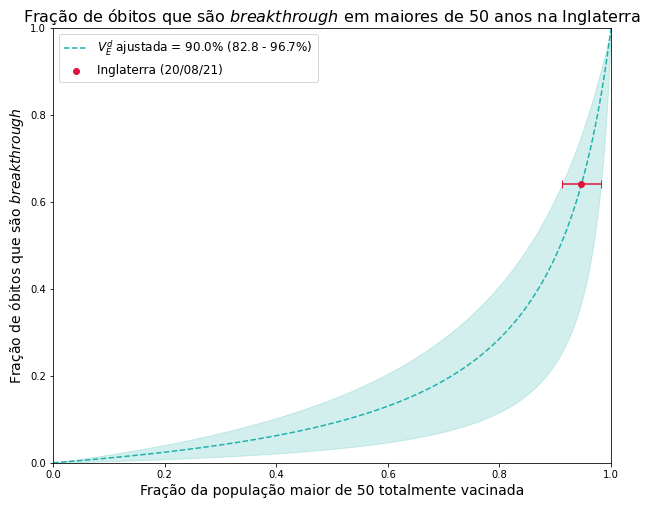

In [129]:
fig = plt.figure(figsize=(10,8))
plt.plot(x, breakthrough(x, c[0]), label = f'$V_E^d$ ajustada = {100*c[0]:.1f}% ({100*c2[0]:.1f} - {100*c3[0]:.1f}%)',
         color = 'lightseagreen', zorder = 0, linestyle = 'dashed')
plt.fill_between(x, breakthrough(x, c2[0]), breakthrough(x, c3[0]), color = 'lightseagreen',
                 alpha = 0.2)
plt.scatter(cover_england/100, 0.641, label = 'Inglaterra (20/08/21)', color = 'crimson')
plt.errorbar(cover_england/100, 0.641, xerr = 0.035, capsize=4, color = 'crimson')
plt.legend(loc = 'upper left', fontsize = 12)
plt.xlabel('Fração da população maior de 50 totalmente vacinada', fontsize = 14)
plt.ylabel(r'Fração de óbitos que são $\it{breakthrough}$', fontsize = 14)
plt.title(r'Fração de óbitos que são $\it{breakthrough}$ em maiores de 50 anos na Inglaterra', fontsize = 16)
plt.xlim(0,1)
plt.ylim(0,1)

fig.patch.set_alpha(1)
for ax in fig.axes:
    ax.patch.set_alpha(1)

### Nota final

É muito importante lembrar que este é um exemplo puramente educativo para que se adquira a noção de que um aumento da proporção de vacinados nos óbitos, ou casos, ou hospitalizações é normal. Além de que a comparação entre os grupos de vacinados e não vacinados PRECISA ser feita em separação por faixas etárias devido ao plano de vacinação.

Um trabalho de cunho científico necessita muito mais rigor e dados com uma qualidade mais específica.